# Importe

In [2]:
#import fundamental libraries
import numpy as np
import math
import scipy.constants as const
from IPython.display import IFrame
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from scipy.integrate import quad
from scipy.optimize import curve_fit
import sympy as sp

plt.style.use('classic')

C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\4229067268.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
# !pip install pint
from pint import UnitRegistry
u = UnitRegistry()

In [5]:
# !pip install iminuit

In [7]:
# from iminuit import Minuit

 # Data

In [9]:
data_path = 'Data/'
muons = f'{data_path}muons.dat'
hadrons = f'{data_path}hadrons.dat'
gev89 = f'{data_path}89gev.dat'
gev91 = f'{data_path}91gev.dat'
gev93 = f'{data_path}93gev.dat'

# Functions

## Data analysis

In [10]:
# Function to read in events from the ASCII data files
def read_events(fname):
    file_content = []
    particle_content = []
    event_content = []
    line_content = []
    muon_max = 0

    # loop over the file on a line by line basis
    for line in open(fname):
        # If the line starts with a "#" it's a comment.
        if (line.startswith("#")):
            continue

        # If the line has 1 entry it contains only the number of particles in the following event.
        # Information in this line is not saved but used to define the event structures

        if len(line.split()) == 1:
            number_of_particles = int(line.split()[0])
            # initialize counter of particles and event content
            count = 0
            event_content=[]
            # initialize event variables
            n_el = 0
            n_mu = 0
            n_had = 0
            n_part = 0
            passes_hadron_selection = 0
            passes_muon_selection = 0
            max_pt = 0.
            Evis = 0
            Elong = 0
            Etrns = 0
            sin = 0
            continue

        # when there are more entries then it's a particle. the information about its momentum and mass are saved in a
        # structured array. another couple of variables are also added
        if len(line.split()) != 1 and count < number_of_particles:

            # Structure containing the information about each particle within the event
            line_content = np.zeros(1, dtype=[('px','float64'), ('py', 'float64'), ('pz', 'float64'), # Momentum components
                                              ('m', 'float64'), # Particle mass
                                              ('p', 'float64'), # Total momentum
                                              ('e', 'float64'), # Total energy
                                              ('pt', 'float64'),('et', 'float64'), # Transverse momentum and energy
                                              ('ez', 'float64')]) # Longitudinal energy

            event_var = np.zeros(1, dtype=[('n_el', 'float64'), # Number of EM particles
                                           ('n_mu', 'float64'), # Number of muons
                                           ('n_had', 'float64'), # Number of hadrons
                                           ('n_part', 'float64'), # Number of particles total
                                           ('max_pt', 'float64'),# Maximum particle transverse momentum
                                           ('muon_max', 'float64'), # most energetic muon REMOVE!
                                            ('Evis', 'float64'), #total calorimatric Energy
                                           ('Elong', 'float64'), #longitudinal Energy imbalance
                                           ('Etrns', 'float64'), #transversal Energy imbalance
                                           ('sin', 'float64')
                                           ])

            # Copy across the particle information from the line read in
            num, px, py, pz, m = [float(item) for item in line.split()]

            # Copy everything into our particle information structure
            line_content['px'] = px
            line_content['py'] = py
            line_content['pz'] = pz
            line_content['m'] = m
            line_content['p'] = math.sqrt(px * px + py * py + pz * pz)
            line_content['pt'] = math.sqrt(px * px + py * py)
            line_content['e'] = math.sqrt(px * px + py * py + pz * pz)
            line_content['et'] = math.sqrt(px * px + py * py)
            line_content['ez'] = math.sqrt(pz * pz)
            event_content.append(line_content)

            if abs(abs(line_content['m'][0]) - 0.106) < 0.001: # This is a muon
                n_mu += 1
                if line_content['e'] > muon_max: # REMOVE
                    muon_max = line_content['e']
            elif abs(abs(line_content['m'][0]) - 0.000) < 0.001:
                n_el += 1 # Photon (based on mass)
            elif abs(abs(line_content['m'][0]) - 0.140) < 0.001:
                n_had += 1 # Hadron (based on mass)

            if line_content['e'] != 0:
                Evis += line_content['e']
                Elong += line_content['ez']
                Etrns += line_content['et']
            # calulating sine
            hyp = np.sqrt(line_content['px']**2 + line_content['py']**2 + line_content['pz']**2)
            sin = line_content['pz'] / hyp

            n_part = number_of_particles
            if line_content['pt'][0] > max_pt:
                max_pt = line_content['pt'][0]
            if count == number_of_particles - 1:
                event_var['n_el'] = n_el
                event_var['n_mu'] = n_mu
                event_var['n_had'] = n_had
                event_var['n_part'] = n_part
                event_var['max_pt'] = max_pt
                event_var['muon_max'] = muon_max #REMOVE
                # muon_max=0
                event_var['Evis'] = Evis
                event_var['Elong'] = Elong
                event_var['Etrns'] = Etrns
                event_var['sin'] = sin
                file_content.append(event_var)
                particle_content.append(event_content)

        count += 1

    return np.array(file_content), particle_content

In [11]:
def cross_section(data_cut, mc, mc_selection, L):    #input: data events after cut, mc daten befor cut and the selection list, L
    crss_sec = (len(data_cut) - sum(background(data_cut, mc[mc_selection])[2])) / (eps_eff(mc_selection, mc) * L)
    return crss_sec                 #return crosssection


In [12]:
# here we can define the cuts to make to select hadron or muon events
def make_hadron_selection(event_properties, Es):

    # define the cuts separately (this is simple example cut)
    part_cut = event_properties[:]["n_part"] >= 15
    part_cut_2 = event_properties[:]["n_part"] < 100000
    part_cut_3 = event_properties[:]["Evis"] / Es < 1.5         #p. 38, L3
    part_cut_4 = event_properties[:]["Evis"] / Es > 0.5          #p. 38, L3

    # Then look for events where all cuts are passed
    selection = np.all((part_cut, part_cut_2,part_cut_3,part_cut_4), axis=0)
    return selection.ravel()# Ravel to make sure output is flat


# Do it again for muons
def make_muon_selection(event_properties, Es):

    part_cut = event_properties[:]["n_part"] >= 1
    part_cut_2 = event_properties[:]["n_part"] < 10
    part_cut_3 = event_properties[:]["n_mu"] >= 2 # p. 40, L3
    part_cut_4 = event_properties[:]["Evis"] / Es > 0.6 #p. 42, L3, Fig. 5.3
    # part_cut_sin = abs(event_properties[:]["sin"]) < 0.8 # L3, p. 40

    selection = np.all((part_cut,
                        part_cut_2,
                        part_cut_3,
                        part_cut_4#,
                        # part_cut_sin
                        ), axis=0)

    return selection.ravel()

In [14]:
def eps_eff(sel, ev):
    """
    eps_eff:      the efficiency
    sel:          selected number of events, N_MC^cut
    ev:           total number of events, N_MC

    It is the equation 7 from the instruction
    """
    return len(ev[sel]) / len(ev)

In [15]:
def background(data, mc_data):
    """
    """
    ld, lm = np.zeros(100), np.zeros(100)
    for i in range(0, len(data)):
        ld[int(data[i])] += 1
    for i in range(0, len(mc_data)):
        lm[int(mc_data[i])] += 1

    # weighting lm
    lm *= sum(ld) / sum(lm)
    # calculating background
    bg = abs(lm - ld)
    return ld, lm, bg


def lu(data):
    d = np.array(data)
    return max(abs(d - (sum(d / 3))))


def cs_u(N, B, L, e, uN, uB, uL, ue, statuN, statuB):
    le = 1 / (L * e)
    u_sys = abs(le) * np.sqrt(uN**2 + uB**2 + ((N - B) * uL / L)**2 + ((N - B) * ue / e)**2)
    u_stat = abs(le) * np.sqrt(statuN**2 + statuB**2)
    return np.sqrt(u_sys**2 + u_stat**2)

## Breit wegner pdf

In [16]:
def chi_squared(sigma, gamma, mass):
    expectation = np.array(convolution2(x, sigma, gamma, mass))
    return np.sum((expectation-np.array(y))**2/np.array(ey)**2)

In [17]:
#definition of stuff you don't really need to look into, here we define the functions for the convolution between the
#breit-wigner and the gaussian
def radcorr(z,s):
    me2    = 0.0000002611200
    alphpi = 0.0023228196
    zeta2  = 1.644934
    cons1  = -2.16487
    cons2  = 9.8406
    cons3  = -6.26
    fac2   = 1.083
    l      = math.log(s/me2)
    beta   = 2.*alphpi*(l-1.)
    del1vs = alphpi*((3./2.)*l+2.*zeta2-2.)
    del2vs = pow(alphpi,2.)*(cons1*pow(l,2.)+cons2*l+cons3)
    delvs  = 1.+del1vs+del2vs
    del1h  = -alphpi*(1.+z)*(l-1.)
    delbh  = pow(alphpi,2.)*(1./2.)*pow((l-1.),2.)*((1.+z)*(3.*math.log(z)-4.*math.log(1.-z))-(4./(1.-z))*math.log(z)-5.-z)
    rad    = beta*pow((1.-z),beta-1.)*delvs+del1h+delbh
    rad *=fac2
    return rad

# Breit-Widgner distribution
def bw(s, s0, g2, m2):
    return s0*(s*g2)/(pow(s-m2,2)+m2*g2)

def bw2(x,pars):
    return bw(pow(x,2),pars[0],pow(pars[1],2),pow(pars[2],2))

def integrand2(x, p0, p1, p2, p3):
    integrand = bw(x*p0,p1,p2,p3)
    integrand *= radcorr(x,p0)

    return integrand

def convolution(s,s0,g2,m2):

    if(s<60):
        print("s too small")
        return -1

    zmin=pow(60,2)/s
    zmax=0.9999999999
    result, error = quad(integrand2, zmin,zmax, args=(s,s0,g2,m2), epsrel=1e-6)
    return result

def convolution2(x, sigma, gamma, mass):
    y_est = []
    for xp in x:
        y_est.append(convolution(pow(xp,2), sigma, pow(gamma,2), pow(mass,2)))
    return y_est

In [18]:
def correlation_from_covariance(covariance):
    errors = np.sqrt(np.diag(covariance))
    outer_errors = np.outer(errors, errors)
    correlation = covariance / outer_errors
    correlation[covariance == 0] = 0
    return correlation

# Data Analysis

## Code Example

In [21]:
#what does an event look like? let's see
#we use only one file for this test
# input_name='89gev.dat'
#we read all events with the class above.
event_properties, particle_properties = read_events(gev89)
#what's the result?
print(event_properties[0])

[(0., 0., 1., 1., 0.25162273, 0., 0.52607794, 0.462, 0.25162273, 0.87819687)]


In [22]:
print(event_properties[0][0][0])

0.0


In [23]:
print(particle_properties[0][0])

[(0.095, 0.233, 0.462, 0.14, 0.52607794, 0.52607794, 0.25162273, 0.25162273, 0.462)]


In [24]:
#this can look confusing so let's try to understand it. we now look only at the first elements in the lists. One
#is a list of variables like px,py,....,ez of the particles. there is only one line because there is only one
#one particle in the event
print(particle_properties[0])

[array([(0.095, 0.233, 0.462, 0.14, 0.52607794, 0.52607794, 0.25162273, 0.25162273, 0.462)],
      dtype=[('px', '<f8'), ('py', '<f8'), ('pz', '<f8'), ('m', '<f8'), ('p', '<f8'), ('e', '<f8'), ('pt', '<f8'), ('et', '<f8'), ('ez', '<f8')])]


In [25]:
# The other is a list of event variables like the total number of electrons in the event, or the maximum pt
# in the event
print(event_properties[0])

[(0., 0., 1., 1., 0.25162273, 0., 0.52607794, 0.462, 0.25162273, 0.87819687)]


In [26]:
#in the second event there are 16 particles, stuff becomes more complicated. let's retrieve the features of the
#first particle only
print(particle_properties[1][0])

[(0.768, 1.249, 3.101, 0.14, 3.43016414, 3.43016414, 1.46622815, 1.46622815, 3.101)]


In [27]:
#and now the second
print(particle_properties[1][1])

[(-0.676, -0.314, 0.265, 0., 0.79107332, 0.79107332, 0.74536702, 0.74536702, 0.265)]


In [28]:
#and so on until the 16th
print(particle_properties[1][15])

[(-0.036, -0.083, 0.095, 0.14, 0.13118689, 0.13118689, 0.09047099, 0.09047099, 0.095)]


In [29]:
#as i said there are also a set of event variables (number of electrons in the event, number of muons, maximum pt)
print(event_properties[1])

[(2., 0., 14., 16., 1.46622815, 0., 9.7082518, 6.626, 6.0144634, 0.72415773)]


## EDA

Now we have the functions to read in the data we can take a look at it and see the effects of changing different cuts on the distributions and see how this will help us to pick the best classifying cuts to select the appropriate hadron and muon Z0 events.

In [30]:
# luminosity in nb^-1, source: instructions ....
L89 = 179.3 # nb^-1
L91 = 135.9
L93 = 151.1

## 89 GeV

### Plot

In [32]:
# input_data_file_89 = "./89gev.dat" # first define which energy range data we want to read in

# Then we get our data from the input file
data_events_89, data_particles_89 = read_events(gev89)

In [ ]:
#we retrieve the muon and hadron MC data
muon_mc_events, muon_mc_particles = read_events(muons)
hadron_mc_events, hadron_mc_particles = read_events(hadrons)

data_var = []
print(len(data_events_89),
      "events in data, ",
      len(muon_mc_events), "muon MC events, ",
      len(hadron_mc_events), "hadron MC events")

10000 events in data,  9969 muon MC events,  10000 hadron MC events


In [36]:
variable = "n_part" # The name of the variable we want to plot
xmin, xmax, nbins = 0., 100, 51 # And the binning of the histogram we want to make (min, max, number of bins)
binning_type = "linear" # And whether we want log or linear binning

# Define the figure we want to draw
figure, ((ax1, ax2, ax3)) = plt.subplots(1, 3,  figsize=(18,5.5))


# Make selections on data and store a bool of those passing
Es = 89.48 # GeV
data_hadron_selection_89 = make_hadron_selection(data_events_89,Es)
data_muon_selection_89 = make_muon_selection(data_events_89, Es)

# Do same for MC muons
muon_mc_hadron_selection = make_hadron_selection(muon_mc_events,Es)
muon_mc_muon_selection = make_muon_selection(muon_mc_events, Es)

# and MC hadrons
hadron_mc_hadron_selection = make_hadron_selection(hadron_mc_events,Es)
hadron_mc_muon_selection = make_muon_selection(hadron_mc_events, Es)

# Define the bins for our histogram as an array of the bin boundaries
if binning_type is "log":
    bins = np.logspace(np.log10(xmin),np.log10(xmax), nbins)
else:
    bins = np.linspace(xmin, xmax, nbins)

# The first histogram we make is our data events vs the MC muon and hadron events with no cuts made
# When comparing histograms we weight MC so that integral is same as data
weight_muon = len(data_events_89) / len(muon_mc_events)
weight_hadron = len(data_events_89) / len(hadron_mc_events)

ax1.hist(data_events_89[:][variable], bins=bins, alpha=0.5, label="data")
ax1.hist(muon_mc_events[:][variable], bins=bins, alpha=0.5, label="MC muons")
ax1.hist(hadron_mc_events[:][variable], bins=bins, alpha=0.5, label="MC hadrons")
ax1.set_xscale(binning_type)
#ax1.set_yscale(binning_type)
ax1.set_ylabel("Number of events", weight="bold")
ax1.set_xlabel(variable, weight="bold")
ax1.legend()

# Next we make the same plot for events passing hadron cuts
weight_muon = np.ones(np.sum(muon_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_89) / np.sum(muon_mc_hadron_selection))
weight_hadron = np.ones(np.sum(hadron_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_89) / np.sum(hadron_mc_hadron_selection))

ax2.hist(data_events_89[data_hadron_selection_89][variable], bins=bins, alpha=0.5, label="data")
ax2.hist(muon_mc_events[muon_mc_hadron_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
ax2.hist(hadron_mc_events[hadron_mc_hadron_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
ax2.set_xscale(binning_type)
#ax2.set_yscale(binning_type)
ax2.set_ylabel("Number of events", weight="bold")
ax2.set_xlabel(variable, weight="bold")
ax2.legend()

# And finally for events passing muon cuts
weight_muon = np.ones(np.sum(muon_mc_muon_selection)) * \
                (np.sum(data_muon_selection_89) / np.sum(muon_mc_muon_selection))
weight_hadron = np.ones(np.sum(hadron_mc_muon_selection)) * \
                (np.sum(data_muon_selection_89) / np.sum(hadron_mc_muon_selection))

ax3.hist(data_events_89[data_muon_selection_89][variable], bins=bins, alpha=0.5, label="data")
ax3.hist(muon_mc_events[muon_mc_muon_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
ax3.hist(hadron_mc_events[hadron_mc_muon_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
ax3.set_xscale(binning_type)
ax3.legend()

ax3.set_ylabel("Number of events", weight="bold")
ax3.set_xlabel(variable, weight="bold")


<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\3945997750.py:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if binning_type is "log":
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\3945997750.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_hadron_selection_89) / np.sum(muon_mc_hadron_selection))
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\3945997750.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_muon_selection_89) / np.sum(hadron_mc_muon_selection))


Text(0.5, 0, 'n_part')

#### Plots for protocoll

In [37]:
# The first histogram we make is our data events vs the MC muon and hadron events with no cuts made
# When comparing histograms we weight MC so that integral is same as data
weight_muon = len(data_events_89) / len(muon_mc_events)
weight_hadron = len(data_events_89) / len(hadron_mc_events)

plt.hist(data_events_89[:][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[:][variable], bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[:][variable], bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
plt.yticks([0,2000,4000,6000])
#ax1.set_yscale(binning_type)
plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
plt.legend()
plt.savefig('89gev-data.png',dpi=600,transparent=True)

C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\3388268265.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_hadron_selection_89) / np.sum(muon_mc_hadron_selection))


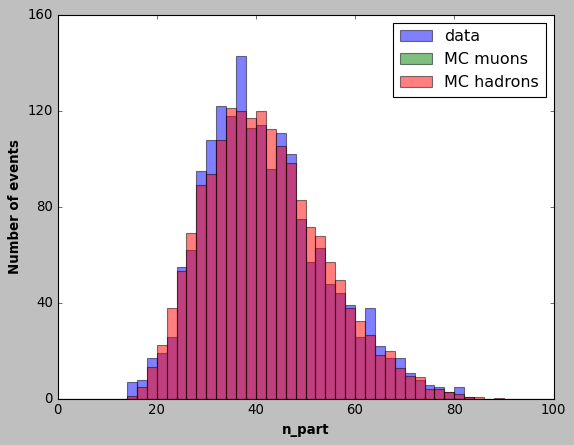

In [41]:
# Next we make the same plot for events passing hadron cuts
weight_muon = np.ones(np.sum(muon_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_89) / np.sum(muon_mc_hadron_selection))
weight_hadron = np.ones(np.sum(hadron_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_89) / np.sum(hadron_mc_hadron_selection))

plt.hist(data_events_89[data_hadron_selection_89][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[muon_mc_hadron_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[hadron_mc_hadron_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
plt.yticks([0,40,80,120,160])
plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
plt.legend()
# plt.savefig('89gev-hadrons.png',dpi=600,transparent=True)
plt.show()

C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\2718177943.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_muon_selection_89) / np.sum(hadron_mc_muon_selection))


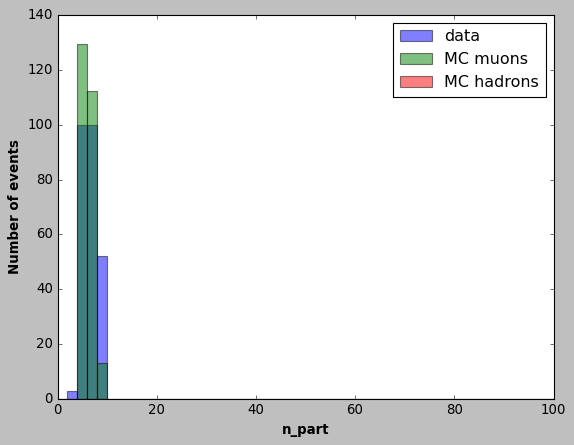

In [42]:
# And finally for events passing muon cuts
weight_muon = np.ones(np.sum(muon_mc_muon_selection)) * \
                (np.sum(data_muon_selection_89) / np.sum(muon_mc_muon_selection))
weight_hadron = np.ones(np.sum(hadron_mc_muon_selection)) * \
                (np.sum(data_muon_selection_89) / np.sum(hadron_mc_muon_selection))

plt.hist(data_events_89[data_muon_selection_89][variable], bins=bins, alpha=0.5,
         label="data")
plt.hist(muon_mc_events[muon_mc_muon_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[hadron_mc_muon_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
# plt.xscale(binning_type)

plt.legend()
# plt.xlim(20)
plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
# plt.savefig('89gev-muons.png',dpi=600,transparent=True)
plt.show()

### Cross section

In [43]:
# epsilon for hadron
eps_h = eps_eff(hadron_mc_hadron_selection,hadron_mc_events)
print(f'Efficiency hadron: {round(eps_h,4)}')
# epsilon for muon
eps_m = eps_eff(muon_mc_muon_selection,muon_mc_events)
print(f'efficiency muon: {round(eps_m,4)}')

Efficiency hadron: 0.9925
efficiency muon: 0.6153


hadron
13.66
19.93
12.92
bg2, left, total events: 1801.0, background: 333.1
muon
36.24
18.49
23.84
bg2, right, total events: 255.0, background: 109.5


C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ld[int(data[i])] += 1
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lm[int(mc_data[i])] += 1


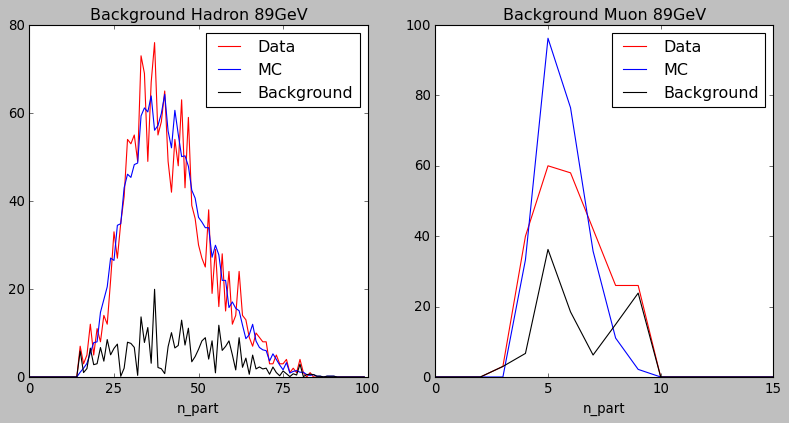

In [44]:
ld89h,lm89h,bg89h = background(data_events_89[data_hadron_selection_89]['n_part'],
                            hadron_mc_events[hadron_mc_hadron_selection]['n_part'])

figure, ((bg1, bg2)) = plt.subplots(1, 2,  figsize=(12,5.5))
Nh89 = sum(ld89h)
Bh89 = sum(lm89h)
print('hadron')
for i in range(len(bg89h)):
  if bg89h[i] >12:
    print(round(bg89h[i],2))
bg1.plot(np.linspace(0,99,100), ld89h,
         color='red',label='Data')
bg1.plot(np.linspace(0,99,100), lm89h,
         color='blue',label='MC')
bg1.plot(np.linspace(0,99,100), bg89h,
         color='k',label='Background')
bg1.legend()
bg1.set_xlim(0,100)
bg1.set_ylim(0,80)
bg1.set_xticks([0,25,50,75,100])
bg1.set_yticks([0,20,40,60,80])
bg1.set_title('Background Hadron 89GeV')
bg1.set_xlabel('n_part')
print(f'bg2, left, total events: {round(Nh89,1)}, background: {round(sum(bg89h),1)}')
# bg1.text(0.6,0.85,'Total events: ' + str(round(Nh89,1)),
#          transform= bg1.transAxes)
# bg1.text(0.6,0.8,'Background: ' + str(round(sum(bg89h),1)),
#          transform= bg1.transAxes)

ld89m,lm89m,bg89m = background(data_events_89[data_muon_selection_89]['n_part'],
                        muon_mc_events[muon_mc_muon_selection]['n_part'])
Nm89 = sum(ld89m)   #total numver events
Bm89 = sum(lm89m)  #total background
print('muon')
for i in range(len(bg89m)):
  if bg89m[i] >18:
    print(round(bg89m[i],2))
bg2.plot(np.linspace(0,99,100), ld89m,color='red',label='Data')
bg2.plot(np.linspace(0,99,100), lm89m,color='blue',
         label='MC')
bg2.plot(np.linspace(0,99,100), bg89m,color='k',
         label='Background')
bg2.set_xlim(0,15)
bg2.set_ylim(0,100)
bg2.set_xticks([0,5,10,15])
bg2.set_xlabel('n_part')
bg2.set_title('Background Muon 89GeV')
bg2.legend()
print(f'bg2, right, total events: {round(Nm89,1)}, background: {round(sum(bg89m),1)}')
# bg2.text(0.5,0.85,'Total events: ' + str(round(Nm89,1)),
#          transform= bg2.transAxes)
# bg2.text(0.5,0.8,'Background: ' + str(round(sum(bg89m),1)),
#          transform= bg2.transAxes)
plt.show()


In [48]:
#calc Cross Section
cs_hadron_89 = cross_section(data_events_89[data_hadron_selection_89]['n_part'],
                        hadron_mc_events[:]['n_part'],
                        hadron_mc_hadron_selection, L89)
cs_muon_89 = cross_section(data_events_89[data_muon_selection_89]['n_part'],
                      muon_mc_events[:]['n_part'],
                      muon_mc_muon_selection, L89)



print('Cross Section Hadron: ' + str(cs_hadron_89))
print('Cross Section Muon: ' + str(cs_muon_89))


#We variated the cut parameter to get different values for background and total events for estimating the systematic uncertainty



#hadron
h_background = [339.0, 337.1, 339.3]
u_h_bkg = lu(h_background)
print('u_h_bkg: ' + str(round(u_h_bkg,2)))

h_totalev = [1787.0, 1768.0, 1793.0]
u_h_n=lu(h_totalev)
print('u_h_n: ' + str(round(u_h_n,2)))

h_eps = [0.983, 0.979, 0.984]
u_h_eps=lu(h_eps)
print('u_h_eps: ' + str(round(u_h_eps,5)))

#muon
m_background = [30.0, 22.9, 33.9]
u_m_bkg = lu(m_background)
print('u_m_bkg: ' + str(round(u_m_bkg,2)))

m_totalev = [82.0, 86.0, 77.0]
u_m_n = lu(m_totalev)
print('u_m_n: ' + str(round(u_m_n,2)))

m_eps = [0.60, 0.61, 0.144]
u_m_eps = lu(m_eps)
print('u_m_eps: ' + str(round(u_m_eps,5)))

#statistic uncertainty via poisson distribution
u_st_h_bkg = np.sqrt(sum(h_background)/3)
u_st_h_n = np.sqrt(sum(h_totalev)/3)
u_st_m_bkg = np.sqrt(sum(m_background)/3)
u_st_m_n = np.sqrt(sum(m_totalev)/3)

print('u_st_h_bkg: ' + str(round(u_st_h_bkg, 2)))
print('u_st_h_n: ' + str(round(u_st_h_n, 2)))
print('u_st_m_bkg: ' + str(round(u_st_m_bkg, 2)))
print('u_st_m_n: ' + str(round(u_st_m_n, 2)))

#calc systematic and statistical uncertainty
u_h_cs = cs_u(Nh89,Bh89,L89,eps_h,u_h_n,u_h_bkg,L89*0.01,u_h_eps,u_st_h_n,u_st_h_bkg)
print('Uncertainty Hadron Crosssection: ' + str(round(u_h_cs,2)))
u_m_cs = cs_u(Nm89,Bm89,L89,eps_m,u_m_n,u_m_bkg,L89*0.01,u_m_eps,u_st_m_n,u_st_m_bkg)
print('Uncertainty Muon Crosssection: ' + str(round(u_m_cs,2)))


Cross Section Hadron: 8.248969930908075
Cross Section Muon: 1.3192001839328824
u_h_bkg: 1.37
u_h_n: 14.67
u_h_eps: 0.003
u_m_bkg: 6.03
u_m_n: 4.67
u_m_eps: 0.30733
u_st_h_bkg: 18.4
u_st_h_n: 42.22
u_st_m_bkg: 5.38
u_st_m_n: 9.04
Uncertainty Hadron Crosssection: 0.27
Uncertainty Muon Crosssection: 0.12


C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ld[int(data[i])] += 1
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lm[int(mc_data[i])] += 1


##### Plots for protocoll

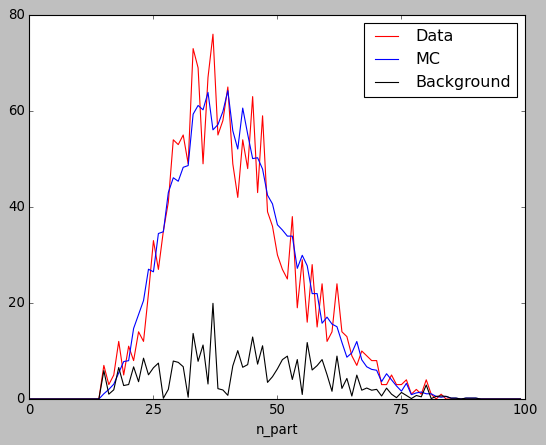

In [49]:
plt.plot(np.linspace(0,99,100), ld89h,
         color='red',label='Data')
plt.plot(np.linspace(0,99,100), lm89h,
         color='blue',label='MC')
plt.plot(np.linspace(0,99,100), bg89h,
         color='k',label='Background')
plt.legend()
plt.xlim(0,100)
plt.ylim(0,80)
plt.xticks([0,25,50,75,100])
plt.yticks([0,20,40,60,80])
# plt.title('Background Hadron 89GeV')
plt.xlabel('n_part')
# plt.savefig('Bg_H_89.png',dpi=600,transparent=True)
plt.show()

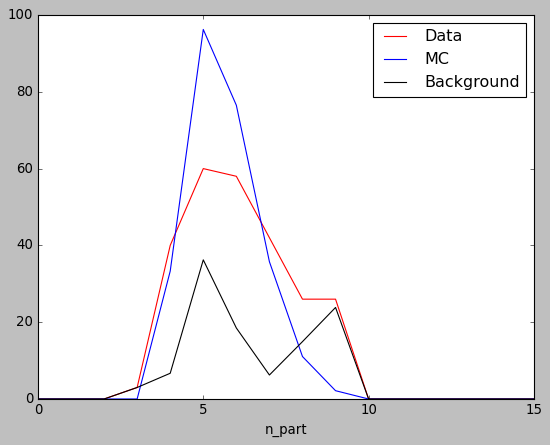

In [50]:

plt.plot(np.linspace(0,99,100), ld89m,color='red',label='Data')
plt.plot(np.linspace(0,99,100), lm89m,color='blue',
         label='MC')
plt.plot(np.linspace(0,99,100), bg89m,color='k',
         label='Background')
plt.xlim(0,15)
plt.ylim(0,100)
plt.xticks([0,5,10,15])
plt.xlabel('n_part')
# plt.set_title('Background Muon 89GeV')
plt.legend()
# plt.savefig('Bg_M_89.png',dpi=600,transparent=True)
plt.show()

## 91 GeV

### plot

In [55]:
# input_data_file_91 = "./91gev.dat" # first define which energy range data we want to read in

# Then we get our data from the input file
data_events_91, data_particles_91 = read_events(gev91)

<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\2426813888.py:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if binning_type is "log":
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\2426813888.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_hadron_selection_91) / np.sum(muon_mc_hadron_selection))
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\2426813888.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_muon_selection_91) / np.sum(hadron_mc_muon_selection))


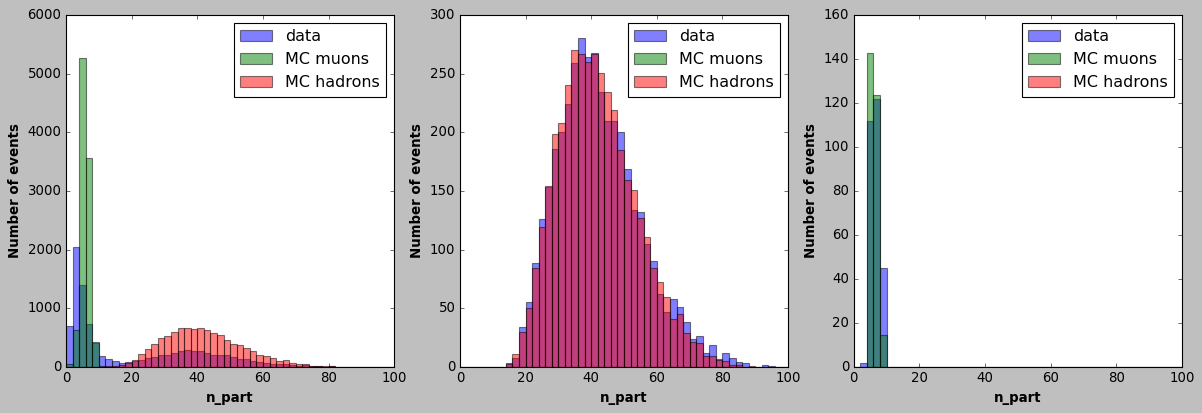

In [57]:
variable = "n_part" # The name of the variable we want to plot
xmin, xmax, nbins = 0., 100, 51 # And the binning of the histogram we want to make (min, max, number of bins)
binning_type = "linear" # And whether we want log or linear binning

# Define the figure we want to draw
figure, ((ax1, ax2, ax3)) = plt.subplots(1, 3,  figsize=(18,5.5))


# Make selections on data and store a bool of those passing
Es = 91.33 # GeV
data_hadron_selection_91 = make_hadron_selection(data_events_91,Es)
data_muon_selection_91 = make_muon_selection(data_events_91, Es)

# Do same for MC muons
muon_mc_hadron_selection = make_hadron_selection(muon_mc_events,Es)
muon_mc_muon_selection = make_muon_selection(muon_mc_events, Es)

# and MC hadrons
hadron_mc_hadron_selection = make_hadron_selection(hadron_mc_events,Es)
hadron_mc_muon_selection = make_muon_selection(hadron_mc_events, Es)

# Define the bins for our histogram as an array of the bin boundaries
if binning_type is "log":
    bins = np.logspace(np.log10(xmin),np.log10(xmax), nbins)
else:
    bins = np.linspace(xmin, xmax, nbins)

# The first histogram we make is our data events vs the MC muon and hadron events with no cuts made
# When comparing histograms we weight MC so that integral is same as data
weight_muon = len(data_events_91) / len(muon_mc_events)
weight_hadron = len(data_events_91) / len(hadron_mc_events)

ax1.hist(data_events_91[:][variable], bins=bins, alpha=0.5, label="data")
ax1.hist(muon_mc_events[:][variable], bins=bins, alpha=0.5, label="MC muons")
ax1.hist(hadron_mc_events[:][variable], bins=bins, alpha=0.5, label="MC hadrons")
ax1.set_xscale(binning_type)
#ax1.set_yscale(binning_type)
ax1.set_ylabel("Number of events", weight="bold")
ax1.set_xlabel(variable, weight="bold")
ax1.legend()

# Next we make the same plot for events passing hadron cuts
weight_muon = np.ones(np.sum(muon_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_91) / np.sum(muon_mc_hadron_selection))
weight_hadron = np.ones(np.sum(hadron_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_91) / np.sum(hadron_mc_hadron_selection))

ax2.hist(data_events_91[data_hadron_selection_91][variable], bins=bins, alpha=0.5, label="data")
ax2.hist(muon_mc_events[muon_mc_hadron_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
ax2.hist(hadron_mc_events[hadron_mc_hadron_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
ax2.set_xscale(binning_type)
#ax2.set_yscale(binning_type)
ax2.set_ylabel("Number of events", weight="bold")
ax2.set_xlabel(variable, weight="bold")
ax2.legend()

# And finally for events passing muon cuts
weight_muon = np.ones(np.sum(muon_mc_muon_selection)) * \
                (np.sum(data_muon_selection_91) / np.sum(muon_mc_muon_selection))
weight_hadron = np.ones(np.sum(hadron_mc_muon_selection)) * \
                (np.sum(data_muon_selection_91) / np.sum(hadron_mc_muon_selection))

ax3.hist(data_events_91[data_muon_selection_91][variable], bins=bins, alpha=0.5, label="data")
ax3.hist(muon_mc_events[muon_mc_muon_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
ax3.hist(hadron_mc_events[hadron_mc_muon_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
ax3.set_xscale(binning_type)
ax3.legend()

ax3.set_ylabel("Number of events", weight="bold")
ax3.set_xlabel(variable, weight="bold")
plt.show()

#### Plots for protocoll

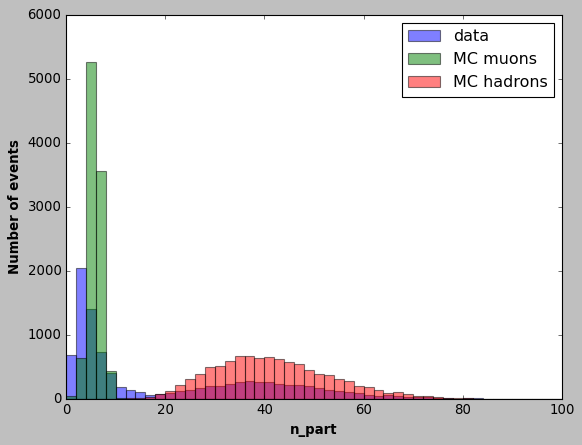

In [58]:
# The first histogram we make is our data events vs the MC muon and hadron events with no cuts made
# When comparing histograms we weight MC so that integral is same as data
weight_muon = len(data_events_91) / len(muon_mc_events)
weight_hadron = len(data_events_91) / len(hadron_mc_events)

plt.hist(data_events_91[:][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[:][variable], bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[:][variable], bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
#ax1.set_yscale(binning_type)
plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
plt.legend()
# plt.savefig('91gev-data.png',dpi=600,transparent=True)
plt.show()

C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\230814568.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_hadron_selection_91) / np.sum(muon_mc_hadron_selection))


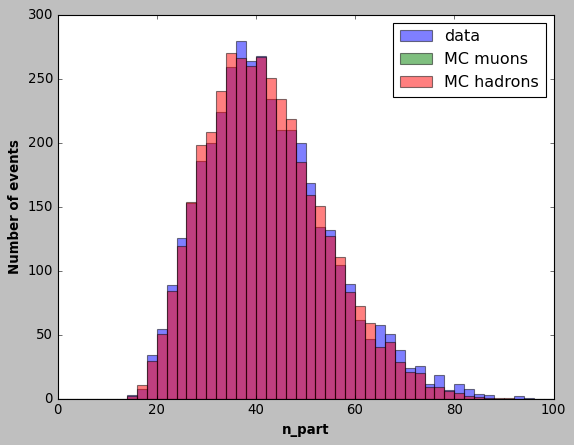

In [60]:
# Next we make the same plot for events passing hadron cuts
weight_muon = np.ones(np.sum(muon_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_91) / np.sum(muon_mc_hadron_selection))
weight_hadron = np.ones(np.sum(hadron_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_91) / np.sum(hadron_mc_hadron_selection))

plt.hist(data_events_91[data_hadron_selection_91][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[muon_mc_hadron_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[hadron_mc_hadron_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
plt.legend()
# plt.savefig('91gev-hadrons.png',dpi=600,transparent=True)
plt.show()

C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\392185828.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_muon_selection_91) / np.sum(hadron_mc_muon_selection))


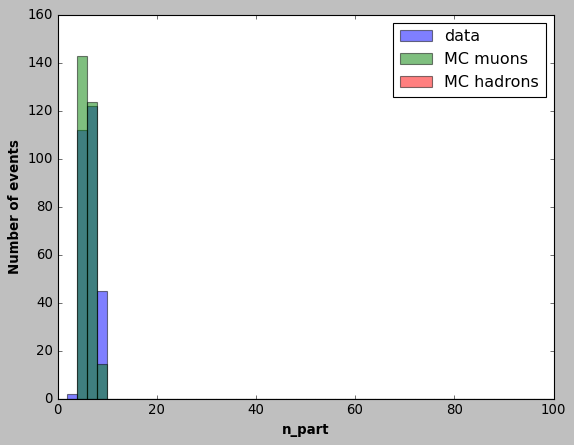

In [63]:
# And finally for events passing muon cuts
weight_muon = np.ones(np.sum(muon_mc_muon_selection)) * \
                (np.sum(data_muon_selection_91) / np.sum(muon_mc_muon_selection))
weight_hadron = np.ones(np.sum(hadron_mc_muon_selection)) * \
                (np.sum(data_muon_selection_91) / np.sum(hadron_mc_muon_selection))

plt.hist(data_events_91[data_muon_selection_91][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[muon_mc_muon_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[hadron_mc_muon_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
plt.legend()

plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
# plt.savefig('91gev-muons.png',dpi=600,transparent=True)
plt.show()

### Cross section

In [65]:
# epsilon for hadron
eps_h = eps_eff(hadron_mc_hadron_selection,hadron_mc_events)
print(f'Efficiency hadron: {round(eps_h,4)}')
# epsilon for muon
eps_m = eps_eff(muon_mc_muon_selection,muon_mc_events)
print(f'efficiency muon: {round(eps_m,4)}')

Efficiency hadron: 0.9928
efficiency muon: 0.6153


C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ld[int(data[i])] += 1
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lm[int(mc_data[i])] += 1


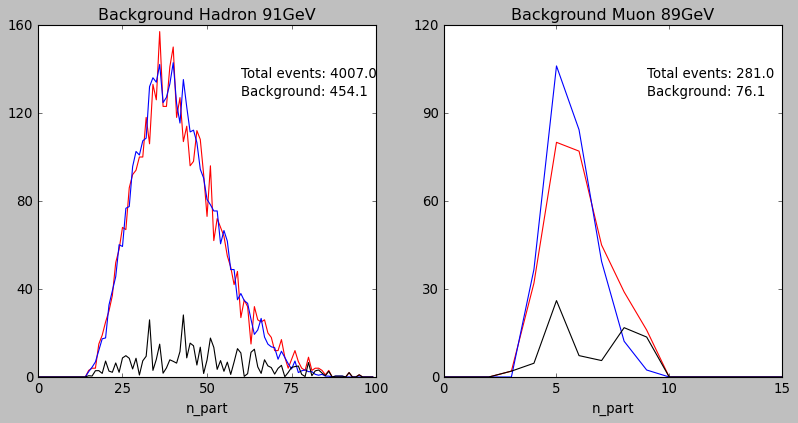

In [66]:
ld91h,lm91h,bg91h = background(data_events_91[data_hadron_selection_91]['n_part'],
                            hadron_mc_events[hadron_mc_hadron_selection]['n_part'])

figure, ((bg1, bg2)) = plt.subplots(1, 2,  figsize=(12,5.5))
Nh91 = sum(ld91h)
Bh91 = sum(lm91h)
bg1.plot(np.linspace(0,99,100), ld91h,
         color='red')
bg1.plot(np.linspace(0,99,100), lm91h,
         color='blue')
bg1.plot(np.linspace(0,99,100), bg91h,
         color='k')
bg1.set_xlim(0,100)
bg1.set_ylim(0,160)
bg1.set_xticks([0,25,50,75,100])
bg1.set_yticks([0,40,80,120,160])
bg1.set_title('Background Hadron 91GeV')
bg1.set_xlabel('n_part')
bg1.text(0.6,0.85,'Total events: ' + str(round(Nh91,1)),
         transform= bg1.transAxes)
bg1.text(0.6,0.8,'Background: ' + str(round(sum(bg91h),1)),
         transform= bg1.transAxes)

ld91m,lm91m,bg91m = background(data_events_91[data_muon_selection_91]['n_part'],
                        muon_mc_events[muon_mc_muon_selection]['n_part'])
Nm91 = sum(ld91m)   #total numver events
Bm91 = sum(lm91m)  #total background
bg2.plot(np.linspace(0,99,100), ld91m,color='red')
bg2.plot(np.linspace(0,99,100), lm91m,color='blue')
bg2.plot(np.linspace(0,99,100), bg91m,color='k')
bg2.set_xlim(0,15)
bg2.set_ylim(0,120)
bg2.set_xticks([0,5,10,15])
bg2.set_yticks([0,30,60,90,120])
bg2.set_xlabel('n_part')
bg2.set_title('Background Muon 89GeV')
bg2.text(0.6,0.85,'Total events: ' + str(round(Nm91,1)),
         transform= bg2.transAxes)
bg2.text(0.6,0.8,'Background: ' + str(round(sum(bg91m),1)),
         transform= bg2.transAxes)
plt.show()


In [67]:
#calc Cross Section
cs_hadron_91 = cross_section(data_events_91[data_hadron_selection_91]['n_part'],
                        hadron_mc_events[:]['n_part'],
                        hadron_mc_hadron_selection, L91)
cs_muon_91 = cross_section(data_events_91[data_muon_selection_91]['n_part'],
                      muon_mc_events[:]['n_part'],
                      muon_mc_muon_selection, L91)



print('Cross Section Hadron: ' + str(cs_hadron_91))
print('Cross Section Muon: ' + str(cs_muon_91))


#We variated the cut parameter to get different values for background and total events for estimating the systematic uncertainty



#hadron
h_background = [448.6, 439.3, 451.8]
u_h_bkg = lu(h_background)
print('u_h_bkg: ' + str(round(u_h_bkg,2)))

h_totalev =  [3966.0, 3933.0, 3981.0]
u_h_n=lu(h_totalev)
print('u_h_n: ' + str(round(u_h_n,2)))

h_eps = [0.983, 0.979, 0.984]
u_h_eps=lu(h_eps)
print('u_h_eps: ' + str(round(u_h_eps,5)))

#muon
m_background = [18.9, 17.7, 24.5]
u_m_bkg = lu(m_background)
print('u_m_bkg: ' + str(round(u_m_bkg,2)))

m_totalev = [134.0, 131.0, 94.0]
u_m_n = lu(m_totalev)
print('u_m_n: ' + str(round(u_m_n,2)))

m_eps = [0.60, 0.61, 0.296]
u_m_eps = lu(m_eps)
print('u_m_eps: ' + str(round(u_m_eps,5)))

#statistic uncertainty via poisson distribution
u_st_h_bkg = np.sqrt(sum(h_background)/3)
u_st_h_n = np.sqrt(sum(h_totalev)/3)
u_st_m_bkg = np.sqrt(sum(m_background)/3)
u_st_m_n = np.sqrt(sum(m_totalev)/3)

print('u_st_h_bkg: ' + str(round(u_st_h_bkg, 2)))
print('u_st_h_n: ' + str(round(u_st_h_n, 2)))
print('u_st_m_bkg: ' + str(round(u_st_m_bkg, 2)))
print('u_st_m_n: ' + str(round(u_st_m_n, 2)))

#calc systematic and statistical uncertainty
u_h_cs = cs_u(Nh91,Bh91,L91,eps_h,u_h_n,u_h_bkg,L91*0.01,u_h_eps,u_st_h_n,u_st_h_bkg)
print('Uncertainty Hadron Crosssection: ' + str(round(u_h_cs,2)))
u_m_cs = cs_u(Nm91,Bm91,L91,eps_m,u_m_n,u_m_bkg,L91*0.01,u_m_eps,u_st_m_n,u_st_m_bkg)
print('Uncertainty Muon Crosssection: ' + str(round(u_m_cs,2)))

Cross Section Hadron: 26.333428594131373
Cross Section Muon: 2.4507082937176685
u_h_bkg: 7.27
u_h_n: 27.0
u_h_eps: 0.003
u_m_bkg: 4.13
u_m_n: 25.67
u_m_eps: 0.206
u_st_h_bkg: 21.13
u_st_h_n: 62.93
u_st_m_bkg: 4.51
u_st_m_n: 10.94
Uncertainty Hadron Crosssection: 0.53
Uncertainty Muon Crosssection: 0.34


C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ld[int(data[i])] += 1
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lm[int(mc_data[i])] += 1


##### plots for protocoll

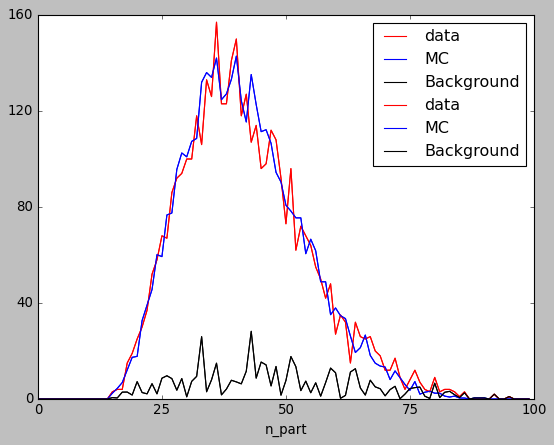

In [69]:
plt.plot(np.linspace(0,99,100), ld91h,
         color='red',label='data')
plt.plot(np.linspace(0,99,100), lm91h,
         color='blue',label='MC')
plt.plot(np.linspace(0,99,100), bg91h,
         color='k',label='Background')
plt.xlim(0,100)
plt.ylim(0,160)
plt.xticks([0,25,50,75,100])
plt.yticks([0,40,80,120,160])
# plt.set_title('Background Hadron 91GeV')
plt.xlabel('n_part')
plt.legend()
# plt.savefig('Bg_H_91.png',dpi=600,transparent=True)
plt.show()

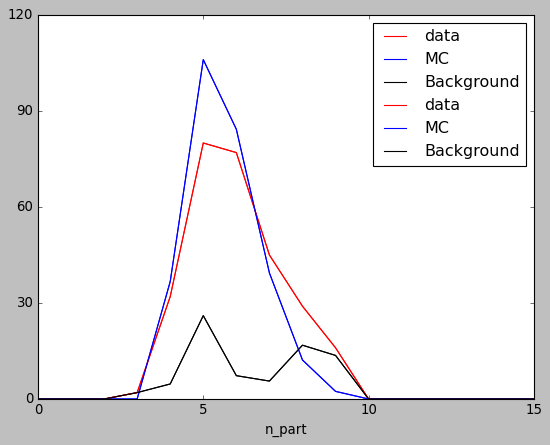

In [71]:
plt.plot(np.linspace(0,99,100), ld91m,
         label='data',color='red')
plt.plot(np.linspace(0,99,100), lm91m,
         label='MC',color='blue')
plt.plot(np.linspace(0,99,100), bg91m,
         label='Background',color='k')
plt.xlim(0,15)
plt.ylim(0,120)
plt.xticks([0,5,10,15])
plt.yticks([0,30,60,90,120])
plt.xlabel('n_part')
# plt.set_title('Background Muon 89GeV')
plt.legend()
# plt.savefig('Bg_M_91.png',dpi=600,transparent=True)
plt.show()

## 93 GeV

#### plot

In [72]:
# input_data_file_93 = "./93gev.dat" # first define which energy range data we want to read in

# Then we get our data from the input file
data_events_93, data_particles_93 = read_events(gev93)

In [73]:
variable = "n_part" # The name of the variable we want to plot
xmin, xmax, nbins = 0., 100, 51 # And the binning of the histogram we want to make (min, max, number of bins)
binning_type = "linear" # And whether we want log or linear binning

# Define the figure we want to draw
figure, ((ax1, ax2, ax3)) = plt.subplots(1, 3,  figsize=(18,5.5))


# Make selections on data and store a bool of those passing
Es = 93.02 # GeV
data_hadron_selection_93 = make_hadron_selection(data_events_93,Es)
data_muon_selection_93 = make_muon_selection(data_events_93, Es)

# Do same for MC muons
muon_mc_hadron_selection = make_hadron_selection(muon_mc_events,Es)
muon_mc_muon_selection = make_muon_selection(muon_mc_events, Es)

# and MC hadrons
hadron_mc_hadron_selection = make_hadron_selection(hadron_mc_events,Es)
hadron_mc_muon_selection = make_muon_selection(hadron_mc_events, Es)

# Define the bins for our histogram as an array of the bin boundaries
if binning_type is "log":
    bins = np.logspace(np.log10(xmin),np.log10(xmax), nbins)
else:
    bins = np.linspace(xmin, xmax, nbins)

# The first histogram we make is our data events vs the MC muon and hadron events with no cuts made
# When comparing histograms we weight MC so that integral is same as data
weight_muon = len(data_events_93) / len(muon_mc_events)
weight_hadron = len(data_events_93) / len(hadron_mc_events)

ax1.hist(data_events_93[:][variable], bins=bins, alpha=0.5, label="data")
ax1.hist(muon_mc_events[:][variable], bins=bins, alpha=0.5, label="MC muons")
ax1.hist(hadron_mc_events[:][variable], bins=bins, alpha=0.5, label="MC hadrons")
ax1.set_xscale(binning_type)
#ax1.set_yscale(binning_type)
ax1.set_ylabel("Number of events", weight="bold")
ax1.set_xlabel(variable, weight="bold")
ax1.legend()

# Next we make the same plot for events passing hadron cuts
weight_muon = np.ones(np.sum(muon_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_93) / np.sum(muon_mc_hadron_selection))
weight_hadron = np.ones(np.sum(hadron_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_93) / np.sum(hadron_mc_hadron_selection))

ax2.hist(data_events_93[data_hadron_selection_93][variable], bins=bins, alpha=0.5, label="data")
ax2.hist(muon_mc_events[muon_mc_hadron_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
ax2.hist(hadron_mc_events[hadron_mc_hadron_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
ax2.set_xscale(binning_type)
#ax2.set_yscale(binning_type)
ax2.set_ylabel("Number of events", weight="bold")
ax2.set_xlabel(variable, weight="bold")
ax2.legend()

# And finally for events passing muon cuts
weight_muon = np.ones(np.sum(muon_mc_muon_selection)) * \
                (np.sum(data_muon_selection_93) / np.sum(muon_mc_muon_selection))
weight_hadron = np.ones(np.sum(hadron_mc_muon_selection)) * \
                (np.sum(data_muon_selection_93) / np.sum(hadron_mc_muon_selection))

ax3.hist(data_events_93[data_muon_selection_93][variable], bins=bins, alpha=0.5, label="data")
ax3.hist(muon_mc_events[muon_mc_muon_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
ax3.hist(hadron_mc_events[hadron_mc_muon_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
ax3.set_xscale(binning_type)
ax3.legend()

ax3.set_ylabel("Number of events", weight="bold")
ax3.set_xlabel(variable, weight="bold")


<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1934944161.py:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if binning_type is "log":
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1934944161.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_hadron_selection_93) / np.sum(muon_mc_hadron_selection))
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1934944161.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_muon_selection_93) / np.sum(hadron_mc_muon_selection))


Text(0.5, 0, 'n_part')

##### plots for protocoll

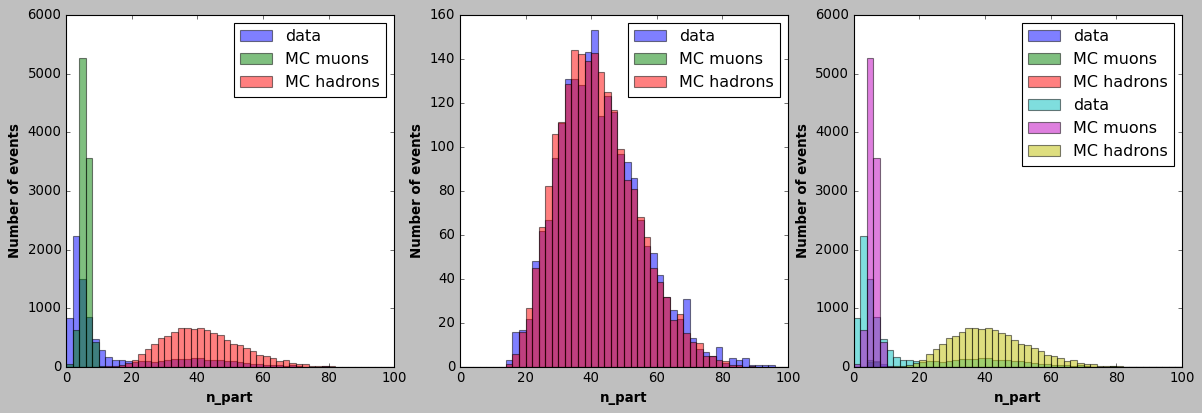

In [74]:
# The first histogram we make is our data events vs the MC muon and hadron events with no cuts made
# When comparing histograms we weight MC so that integral is same as data
weight_muon = len(data_events_93) / len(muon_mc_events)
weight_hadron = len(data_events_93) / len(hadron_mc_events)

plt.hist(data_events_93[:][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[:][variable], bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[:][variable], bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
#ax1.set_yscale(binning_type)
plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
plt.legend()
# plt.savefig('93gev-data.png',dpi=600,transparent=True)
plt.show()

In [75]:
# Next we make the same plot for events passing hadron cuts
weight_muon = np.ones(np.sum(muon_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_93) / np.sum(muon_mc_hadron_selection))
weight_hadron = np.ones(np.sum(hadron_mc_hadron_selection)) * \
                (np.sum(data_hadron_selection_93) / np.sum(hadron_mc_hadron_selection))

plt.hist(data_events_93[data_hadron_selection_93][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[muon_mc_hadron_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[hadron_mc_hadron_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
plt.legend()
plt.savefig('93gev-hadrons.png',dpi=600,transparent=True)

C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\2127102035.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_hadron_selection_93) / np.sum(muon_mc_hadron_selection))


<ipython-input-49-d2daa99ecbda>:5: RuntimeWarning: divide by zero encountered in scalar divide
  (np.sum(data_muon_selection_93) / np.sum(hadron_mc_muon_selection))


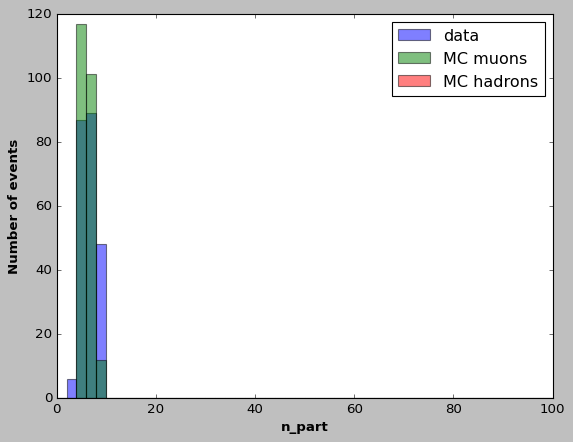

In [ ]:
# And finally for events passing muon cuts
weight_muon = np.ones(np.sum(muon_mc_muon_selection)) * \
                (np.sum(data_muon_selection_93) / np.sum(muon_mc_muon_selection))
weight_hadron = np.ones(np.sum(hadron_mc_muon_selection)) * \
                (np.sum(data_muon_selection_93) / np.sum(hadron_mc_muon_selection))

plt.hist(data_events_93[data_muon_selection_93][variable], bins=bins, alpha=0.5, label="data")
plt.hist(muon_mc_events[muon_mc_muon_selection][variable], weights=weight_muon,
         bins=bins, alpha=0.5, label="MC muons")
plt.hist(hadron_mc_events[hadron_mc_muon_selection][variable], weights=weight_hadron,
         bins=bins, alpha=0.5, label="MC hadrons")
plt.xscale(binning_type)
plt.legend()

plt.ylabel("Number of events", weight="bold")
plt.xlabel(variable, weight="bold")
plt.savefig('93gev-muons.png',dpi=600,transparent=True)

### Cross section

In [76]:
# epsilon for hadron
eps_h = eps_eff(hadron_mc_hadron_selection,hadron_mc_events)
print(f'Efficiency hadron: {round(eps_h,4)}')
# epsilon for muon
eps_m = eps_eff(muon_mc_muon_selection,muon_mc_events)
print(f'efficiency muon: {round(eps_m,4)}')

Efficiency hadron: 0.9923
efficiency muon: 0.6153


C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ld[int(data[i])] += 1
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lm[int(mc_data[i])] += 1


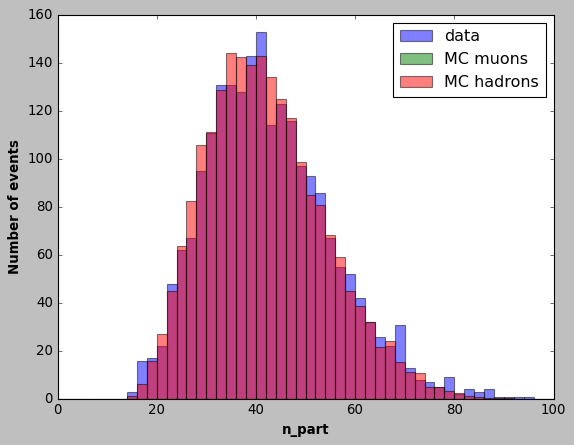

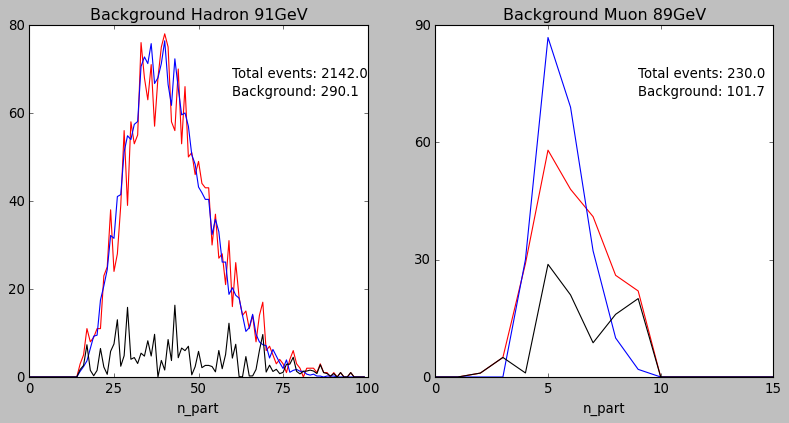

In [77]:
ld93h,lm93h,bg93h = background(data_events_93[data_hadron_selection_93]['n_part'],
                            hadron_mc_events[hadron_mc_hadron_selection]['n_part'])

figure, ((bg1, bg2)) = plt.subplots(1, 2,  figsize=(12,5.5))
Nh93 = sum(ld93h)
Bh93 = sum(lm93h)
bg1.plot(np.linspace(0,99,100), ld93h,
         color='red')
bg1.plot(np.linspace(0,99,100), lm93h,
         color='blue')
bg1.plot(np.linspace(0,99,100), bg93h,
         color='k')
bg1.set_xlim(0,100)
bg1.set_ylim(0,80)
bg1.set_xticks([0,25,50,75,100])
bg1.set_yticks([0,20,40,60,80])
bg1.set_title('Background Hadron 91GeV')
bg1.set_xlabel('n_part')
bg1.text(0.6,0.85,'Total events: ' + str(round(Nh93,1)),
         transform= bg1.transAxes)
bg1.text(0.6,0.8,'Background: ' + str(round(sum(bg93h),1)),
         transform= bg1.transAxes)

ld93m,lm93m,bg93m = background(data_events_93[data_muon_selection_93]['n_part'],
                        muon_mc_events[muon_mc_muon_selection]['n_part'])
Nm93 = sum(ld93m)   #total numver events
Bm93 = sum(lm93m)  #total background
bg2.plot(np.linspace(0,99,100), ld93m,color='red')
bg2.plot(np.linspace(0,99,100), lm93m,color='blue')
bg2.plot(np.linspace(0,99,100), bg93m,color='k')
bg2.set_xlim(0,15)
bg2.set_ylim(0,90)
bg2.set_xticks([0,5,10,15])
bg2.set_yticks([0,30,60,90])
bg2.set_xlabel('n_part')
bg2.set_title('Background Muon 89GeV')
bg2.text(0.6,0.85,'Total events: ' + str(round(Nm93,1)),
         transform= bg2.transAxes)
bg2.text(0.6,0.8,'Background: ' + str(round(sum(bg93m),1)),
         transform= bg2.transAxes)
plt.show()


In [78]:
#calc Cross Section
cs_hadron_93 = cross_section(data_events_93[data_hadron_selection_93]['n_part'],
                        hadron_mc_events[:]['n_part'],
                        hadron_mc_hadron_selection, L93)
cs_muon_93 = cross_section(data_events_93[data_muon_selection_93]['n_part'],
                      muon_mc_events[:]['n_part'],
                      muon_mc_muon_selection, L93)



print('Cross Section Hadron: ' + str(cs_hadron_93))
print('Cross Section Muon: ' + str(cs_muon_93))


#We variated the cut parameter to get different values for background and total events for estimating the systematic uncertainty



#hadron
h_background = [289, 281.9, 292.5]
u_h_bkg = lu(h_background)
print('u_h_bkg: ' + str(round(u_h_bkg,2)))

h_totalev =  [2124.0, 2103.0, 2129.0]
u_h_n=lu(h_totalev)
print('u_h_n: ' + str(round(u_h_n,2)))

h_eps = [0.983, 0.978, 0.984]
u_h_eps=lu(h_eps)
print('u_h_eps: ' + str(round(u_h_eps,5)))

#muon
m_background =[18.2, 17.0, 12.9]
u_m_bkg = lu(m_background)
print('u_m_bkg: ' + str(round(u_m_bkg,2)))

m_totalev = [81.0, 81.0, 57.0]
u_m_n = lu(m_totalev)
print('u_m_n: ' + str(round(u_m_n,2)))

m_eps = [0.60, 0.61, 0.3]
u_m_eps = lu(m_eps)
print('u_m_eps: ' + str(round(u_m_eps,5)))

#statistic uncertainty via poisson distribution
u_st_h_bkg = np.sqrt(sum(h_background)/3)
u_st_h_n = np.sqrt(sum(h_totalev)/3)
u_st_m_bkg = np.sqrt(sum(m_background)/3)
u_st_m_n = np.sqrt(sum(m_totalev)/3)

print('u_st_h_bkg: ' + str(round(u_st_h_bkg, 2)))
print('u_st_h_n: ' + str(round(u_st_h_n, 2)))
print('u_st_m_bkg: ' + str(round(u_st_m_bkg, 2)))
print('u_st_m_n: ' + str(round(u_st_m_n, 2)))

#calc systematic and statistical uncertainty
u_h_cs = cs_u(Nh93,Bh91,L93,eps_h,u_h_n,u_h_bkg,L93*0.01,u_h_eps,u_st_h_n,u_st_h_bkg)
print('Uncertainty Hadron Crosssection: ' + str(round(u_h_cs,2)))
u_m_cs = cs_u(Nm93,Bm91,L93,eps_m,u_m_n,u_m_bkg,L93*0.01,u_m_eps,u_st_m_n,u_st_m_bkg)
print('Uncertainty Muon Crosssection: ' + str(round(u_m_cs,2)))

Cross Section Hadron: 12.35139175971756
Cross Section Muon: 1.3804056908367317
u_h_bkg: 5.9
u_h_n: 15.67
u_h_eps: 0.00367
u_m_bkg: 3.13
u_m_n: 16.0
u_m_eps: 0.20333
u_st_h_bkg: 16.96
u_st_h_n: 46.03
u_st_m_bkg: 4.0
u_st_m_n: 8.54
Uncertainty Hadron Crosssection: 0.37
Uncertainty Muon Crosssection: 0.27


C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ld[int(data[i])] += 1
C:\Users\benjf\AppData\Local\Temp\ipykernel_2792\1543388240.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lm[int(mc_data[i])] += 1


##### plots for protocoll

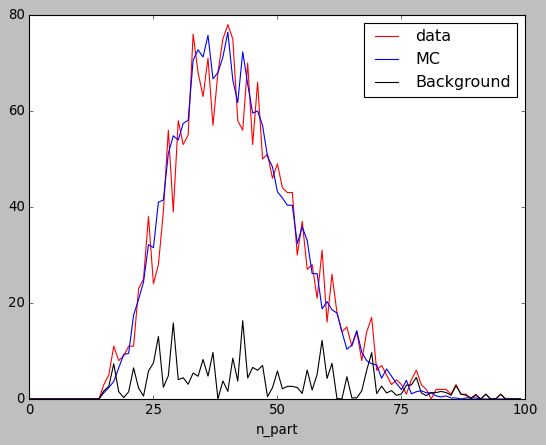

In [79]:
plt.plot(np.linspace(0,99,100), ld93h,
         color='red',label='data')
plt.plot(np.linspace(0,99,100), lm93h,
         color='blue',label='MC')
plt.plot(np.linspace(0,99,100), bg93h,
         color='k',label='Background')
plt.xlim(0,100)
plt.ylim(0,80)
plt.xticks([0,25,50,75,100])
plt.yticks([0,20,40,60,80])
# plt.title('Background Hadron 93GeV')
plt.xlabel('n_part')
plt.legend()
# plt.savefig('Bg_H_93.png',dpi=600,transparent=True)
plt.show()

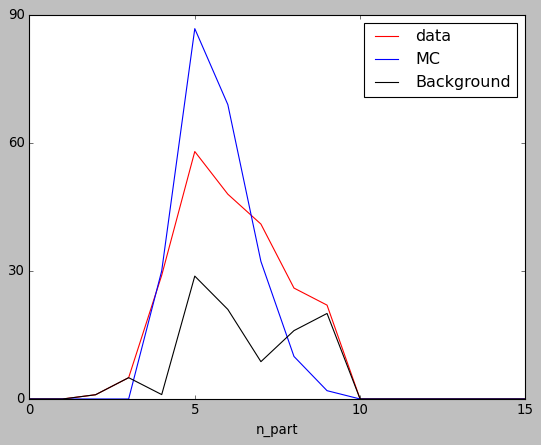

In [80]:
plt.plot(np.linspace(0,99,100), ld93m,color='red',
         label='data')
plt.plot(np.linspace(0,99,100), lm93m,color='blue',
         label='MC')
plt.plot(np.linspace(0,99,100), bg93m,color='k',
         label='Background')
plt.xlim(0,15)
plt.ylim(0,90)
plt.xticks([0,5,10,15])
plt.yticks([0,30,60,90])
plt.xlabel('n_part')
# plt.set_title('Background Muon 93GeV')
plt.legend()
# plt.savefig('Bg_M_93.png',dpi=600,transparent=True)
plt.show()

# Fitting the Breit Wigner pdf

The final functions provided calculate the required "r" parameter and perform the integration required to compute the corrected Breit-Wigner PDF. The funtions are provided to perform the fit to the cross section measurements at the 3 energies, calculated in the previous sections.

In [82]:
# y values with errors
crs_sec_h = np.array([8.2,26.3,12.4])
crs_sec_m = np.array([1.32,2.5,1.4])

err_h_cs = np.array([0.3,0.5,0.4])
err_m_cs = np.array([0.12,0.3,0.3])

Sigma: 32.954989254543555 +- 0.6809431598312014
Gamma: 2.478606603298044 +- 0.06856959696562988
Mass: 91.2431983391881 +- 0.038513214924283994
Covariance Matrix:
[[ 4.63683587e-01 -3.21051422e-02 -1.02659204e-03]
 [-3.21051422e-02  4.70178963e-03  3.96797685e-04]
 [-1.02659204e-03  3.96797685e-04  1.48326772e-03]]


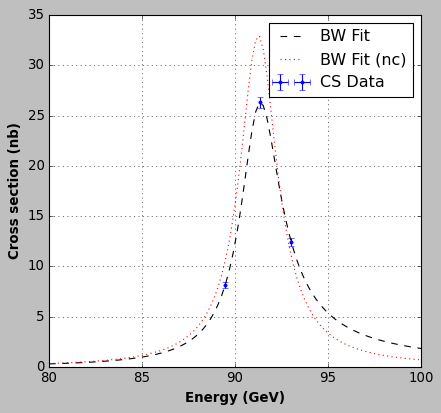

In [83]:
#now we want to perform a fit for hadrons
#we have three energy-points
npoints=3
#here you need to declare the energy-vs-cross section and the errors from your estimation
x= [89.48,91.33,93.03]
y= [8.2,26.3,12.4]
ex= [0.,0.,0.]
ey= [0.3,0.5,0.4]


fit_parameters,conv_m = curve_fit(convolution2, x, y, p0=[70, 5, 90], #p0 gives initial fit parameters
                                       sigma=ey, absolute_sigma=True)
errors = np.sqrt(np.diag(conv_m))


# Make a plot of the best fit values in comparison to measurements
plt.figure(figsize=(6,5.5))
plt.errorbar(x, y, xerr=ex, yerr=ey, fmt=".", label="CS Data")

# Evaluate our fitted function at lots of values of energy to make a line
# then draw it on top of the points
fit_x = np.linspace(80,100,100)
plt.plot(fit_x, convolution2(fit_x, *fit_parameters), color="black", linestyle="dashed", label="BW Fit")
plt.plot(fit_x, bw2(fit_x, (fit_parameters[0], fit_parameters[1], fit_parameters[2])),
         color="red", linestyle="dotted", label="BW Fit (nc)")

plt.xlabel("Energy (GeV)", weight="bold")
plt.ylabel("Cross section (nb)", weight="bold")
plt.legend(loc='upper right')
plt.grid()
print("Sigma:", fit_parameters[0], "+-", errors[0])
print("Gamma:", fit_parameters[1], "+-", errors[1])
print("Mass:", fit_parameters[2],"+-", errors[2])

# And the covariance matrix
print("Covariance Matrix:")
print(conv_m)
sigma_hadron_fit, gamma_hadron_fit, mass_hadron_fit = fit_parameters
sigma_hadron_fit_error, gamma_hadron_fit_error, mass_hadron_fit_error = errors
# plt.savefig('bw-pdf-hadrons.png',dpi=600,transparent=True)
plt.show()

In [84]:
corr_hadron = correlation_from_covariance(conv_m)
print(corr_hadron)

[[ 1.         -0.6875941  -0.03914509]
 [-0.6875941   1.          0.15025459]
 [-0.03914509  0.15025459  1.        ]]


In [85]:
#now we want to perform a fit for muons, try to implement it by yourself

Sigma: 3.0565437629993655 +- 0.4499973789219367
Gamma: 3.406231678147924 +- 0.7975009506081223
Mass: 90.9768817066737 +- 0.23181029783213697
Covariance Matrix:
[[ 0.20249764 -0.29663511 -0.0298486 ]
 [-0.29663511  0.63600777  0.11816578]
 [-0.0298486   0.11816578  0.05373601]]


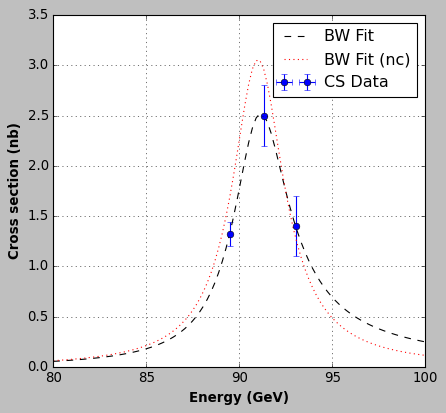

In [86]:
npoints=3
#here you need to declare the energy-vs-cross section and the errors from your estimation
x= [89.48,91.33,93.03]
y= [1.32,2.5,1.4] # These values are of course example guess values, replace them with your own
ex= [0.,0.,0.]
ey= [0.12,0.3,0.3]

fit_parameters, cov_matrix = curve_fit(convolution2, x, y, p0=[70, 5, 90], #p0 gives initial fit parameters
                                       sigma=ey, absolute_sigma=True)
errors = np.sqrt(np.diag(cov_matrix))
plt.figure(figsize=(6,5.5))
plt.errorbar(x, y, xerr=ex, yerr=ey, fmt="o", label="CS Data")
fit_x = np.linspace(80,100,100)
plt.plot(fit_x, convolution2(fit_x, *fit_parameters), color="black", linestyle="dashed", label="BW Fit")
plt.plot(fit_x, bw2(fit_x, (fit_parameters[0], fit_parameters[1], fit_parameters[2])),
         color="red", linestyle="dotted", label="BW Fit (nc)")

plt.xlabel("Energy (GeV)", weight="bold")
plt.ylabel("Cross section (nb)", weight="bold")
plt.legend(loc='upper right')
plt.grid()

print("Sigma:", fit_parameters[0], "+-", errors[0])
print("Gamma:", fit_parameters[1], "+-", errors[1])
print("Mass:", fit_parameters[2],"+-", errors[2])

print("Covariance Matrix:")
print(cov_matrix)
sigma_muon_fit, gamma_muon_fit, mass_muon_fit = fit_parameters
sigma_muon_fit_error, gamma_muon_fit_error, mass_muon_fit_error = errors
# plt.savefig('bw-pdf-muons.png',dpi=600,transparent=True)
plt.show()

In [87]:
corr_muon = correlation_from_covariance(cov_matrix)
print(corr_muon)

[[ 1.         -0.82657328 -0.28614178]
 [-0.82657328  1.          0.63918678]
 [-0.28614178  0.63918678  1.        ]]


In [88]:
M_h = mass_hadron_fit                    #measurements
M_m = mass_muon_fit
s_h = sigma_hadron_fit
s_m = sigma_muon_fit
g_h = gamma_hadron_fit
g_m = gamma_muon_fit


u_M_h = mass_hadron_fit_error              #uncertainties
u_M_m = mass_muon_fit_error
u_s_h = sigma_hadron_fit_error
u_s_m = sigma_muon_fit_error
u_g_h = gamma_hadron_fit_error
u_g_m = gamma_muon_fit_error




print('Gamma Z Boson: (' + str(round(g_h,3)) + ' +/- '
      + str(round(u_g_h,3)) + ') GeV')
nb = (10**(-37))/(1.97327*10**-7)**2   #for calculating 1nb in 1/eV**2
g_lep = np.sqrt(s_m*nb*1e18*(g_h)**2*(M_h)**2/(12*np.pi))  #result in GeV

s,M,g = sp.symbols('s,M,g')
gamma_lep = sp.sqrt(s*nb*1e18*(g)**2*(M)**2/(12*np.pi))
u_gamma_lep = sp.sqrt( (sp.diff(gamma_lep, s)*u_s_m*nb*1e18)**2
                   +(sp.diff(gamma_lep, g)*u_g_h)**2
                   +(sp.diff(gamma_lep, M)*u_M_h)**2
                +2*(sp.diff(gamma_lep, g)*sp.diff(gamma_lep, M)*corr_hadron[1][2]
                   ) )
u_g_lep = u_gamma_lep.subs({s:s_m,g:g_h,M:M_h})
print('Gamma Lepton: (' + str(round(g_lep*1e3,2)) + ' +/- '
      + str(round(u_g_lep*1e3,2)) + ') MeV')



G_F = 1.166e-5
g_neu = G_F*M_h**3/(24*np.sqrt(2)*np.pi)*2
gamma_neu = G_F*M**3/(24*np.sqrt(2)*np.pi)*2
u_gamma_neu = sp.sqrt( (sp.diff(gamma_neu, M)*u_M_h)**2)
u_g_neu = u_gamma_neu.subs(M, M_h)
print('Gamma Neutrino: (' + str(round(g_neu,5)) + ' +/- '
      + str(round(u_g_neu,5)) + ') GeV')


g1,g2,g3 = sp.symbols('g1,g2,g3')
g_had = g_h - 3*g_neu - 3*g_lep
gamma_had = g1 - 3*g2 - 3*g3
u_gamma_had = sp.sqrt((sp.diff(gamma_had,g1)*u_g_h)**2
                      + (sp.diff(gamma_had,g2)*u_g_neu)**2
                      + (sp.diff(gamma_had,g3)*u_g_lep)**2)
u_g_had = u_gamma_had.subs({g1:g_h, g2: g_neu, g3:g_had})
print('Gamma Hadron: (' + str(round(g_had,3)) + ' +/- '
      + str(round(u_g_had,3)) + ') GeV')


g_lep2 = s_h*nb*10**18*(g_h)**2*(M_h)**2/(12*np.pi*g_had)
gamma_lep2 = s*nb*10**18*(g)**2*(M)**2/(12*np.pi*g2)
u_gamma_lep2 = sp.sqrt((sp.diff(gamma_lep2,s)*u_s_h)**2
                      + (sp.diff(gamma_lep2,g)*u_g_h)**2
                      + (sp.diff(gamma_lep2,M)*u_M_h)**2
                      + (sp.diff(gamma_lep2,g2)*u_g_had)**2
                      +2*abs(sp.diff(gamma_lep, s)*sp.diff(gamma_lep, g)*corr_hadron[0][1]
                         +sp.diff(gamma_lep, s)*sp.diff(gamma_lep, M)*corr_hadron[0][2]
                         +sp.diff(gamma_lep, g)*sp.diff(gamma_lep, M)*corr_hadron[1][2]
                      )  )
u_g_lep2 = u_gamma_lep2.subs({s:s_h, g:g_h, M:M_h, g2: g_had})
print('\nGamma Lepton 2: (' + str(round(g_lep2,5)) + ' +/- '
      + str(round(u_g_lep2,5)) + ') GeV')

Gamma Z Boson: (2.479 +/- 0.069) GeV
Gamma Lepton: (103.2 +/- 4.72) MeV
Gamma Neutrino: (0.16613 +/- 0.00021) GeV
Gamma Hadron: (1.671 +/- 0.070) GeV

Gamma Lepton 2: (0.06873 +/- 0.02899) GeV


In [89]:
dscr = G_F*M_h**3/(24*np.sqrt(2)*np.pi)
print(dscr)
sin2_theta_plus = 1/4*(np.sqrt(abs(g_lep*1e-3/dscr -1)) + 1)
sin2_theta_minus = 1/4*(-np.sqrt(abs(g_lep*1e-3/dscr -1)) + 1)
print('sin^2+: ' + str(round(sin2_theta_plus,6)))
print('sin^2-: ' + str(round(sin2_theta_minus,6)))

0.08306612258387369
sin^2+: 0.499845
sin^2-: 0.000155


In [90]:
Q_u = 2/3
Q_d = -1/3

g_u = G_F*M_h**3/(24*np.sqrt(2)*np.pi)*  (1 + (1 - 4*Q_u*sin2_theta_minus)**2)
print('Gamme Up-Quark: ' + str(round(g_u,4)) + ' GeV')

g_d = G_F*M_h**3/(24*np.sqrt(2)*np.pi)*  (1 + (1 - 4*abs(Q_d)*sin2_theta_minus)**2)
print('Gamme Down-Quark: ' + str(round(g_d,4)) + ' GeV')

k_QCD = 1.04
N_C = g_had/((2*g_u + 3*g_d)*k_QCD)
print(round(N_C,0))

Gamme Up-Quark: 0.1661 GeV
Gamme Down-Quark: 0.1661 GeV
2.0
